In [1]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [3]:
ee.Initialize()

In [4]:
# define basic parameters
year_span = [f'{i}_{i+2}' for i in range(1990,2020,3)]

### Step_1: Prepare input classification_img, control_sample, and sample_size

In [5]:
# import the untouched control points, which are diveded by a random column with a 101 random state
Sample_Landsat  = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Control_points")\
                    .randomColumn('split', 101)\
                    .filterMetadata('split','less_than',0.25)

Sample_Sentinel = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Sentinel_2017_2019")\
                    .randomColumn('split', 101)\
                    .filterMetadata('split','less_than',0.25)

In [6]:
# import the classified imgs
Classified_Landsat_1990_2019  = {f'Landsat_{year}':( ee.ImageCollection(f"users/wangjinzhulala/North_China_Plain_Python/classification_img/Tree_50_{year}").sum(),
                                                     Sample_Landsat,Sample_Landsat.size().getInfo())
                                for year in year_span}   
                                 

Classified_Sentinel_2014_2019 = {f'Sentinel_{year}':(ee.ImageCollection(f"users/wangjinzhulala/North_China_Plain_Python/classification_img/Sentinel_Landsat_{year}").sum(),
                                                    Sample_Sentinel,Sample_Sentinel.size().getInfo())   
                                 for year in year_span[-2:]}


# merge two sets of classification together
classified_img_sample = Classified_Landsat_1990_2019.copy()
classified_img_sample.update(Classified_Sentinel_2014_2019)

In [7]:
Input_df = pd.DataFrame(classified_img_sample).T
Input_df.columns = ['classification_img','sample_pt','sample_size']
Input_df

,classification_img,sample_pt,sample_size
Landsat_1990_1992,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980
Landsat_1993_1995,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980
Landsat_1996_1998,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980
Landsat_1999_2001,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980
Landsat_2002_2004,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980
Landsat_2005_2007,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980
Landsat_2008_2010,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980
Landsat_2011_2013,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980
Landsat_2014_2016,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980
Landsat_2017_2019,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980


### Step_2: Loop through each threshold and extract classification value to samples for later comparsion

In [7]:
Threshold_acc = {}

for idx,row in Input_df.iterrows():
    
    img = row[0]
    sample = row[1]
    sample_size = row[2]
    
    for threshold in range(10):
    
        # apply the threshold to the sum of 10 classifications,rename so we can use Accuracyassement module
        img_threshold = img.gt(threshold).rename('classification')

        # extract reclassified GAIA pixel value to test_sample
        sample_with_value = img_threshold.sampleRegions(collection = sample, 
                                                        properties = ['Built'], 
                                                        scale      = 30)

        # Put the result into a dict
        Threshold_acc[(idx,threshold)] = [sample_with_value,sample_size]

In [8]:
# formating the dataframe
Threshold_acc_df = pd.DataFrame(Threshold_acc).T
Threshold_acc_df.reset_index(inplace=True)
Threshold_acc_df.columns = ['Year','Threshold','Feature','Sample_size']

In [9]:
Threshold_acc_df

,Year,Threshold,Feature,Sample_size
0,Landsat_1990_1992,0,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980
1,Landsat_1990_1992,1,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980
2,Landsat_1990_1992,2,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980
3,Landsat_1990_1992,3,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980
4,Landsat_1990_1992,4,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980
...,...,...,...,...
115,Sentinel_2017_2019,5,"ee.FeatureCollection({\n ""type"": ""Invocation""...",2017
116,Sentinel_2017_2019,6,"ee.FeatureCollection({\n ""type"": ""Invocation""...",2017
117,Sentinel_2017_2019,7,"ee.FeatureCollection({\n ""type"": ""Invocation""...",2017
118,Sentinel_2017_2019,8,"ee.FeatureCollection({\n ""type"": ""Invocation""...",2017


### Step_3: Calculate the number of correct classified points, then get the accuracy

In [23]:
correct_num_list = []

for idx,row in Threshold_acc_df.iterrows():
    
    # If the 'Built' and 'classification' attribute are same, then it will be a correct classified point
    correct_num = row[2].filter(ee.Filter.equals('Built',None,'classification')).size().getInfo()
    correct_num_list.append(correct_num)
    
    print(f'Compute the correct classified points number of {row[0]}_{row[1]} finished')

Compute the correct classified points number of Landsat_1990_1992_0 finished
Compute the correct classified points number of Landsat_1990_1992_1 finished
Compute the correct classified points number of Landsat_1990_1992_2 finished
Compute the correct classified points number of Landsat_1990_1992_3 finished
Compute the correct classified points number of Landsat_1990_1992_4 finished
Compute the correct classified points number of Landsat_1990_1992_5 finished
Compute the correct classified points number of Landsat_1990_1992_6 finished
Compute the correct classified points number of Landsat_1990_1992_7 finished
Compute the correct classified points number of Landsat_1990_1992_8 finished
Compute the correct classified points number of Landsat_1990_1992_9 finished
Compute the correct classified points number of Landsat_1993_1995_0 finished
Compute the correct classified points number of Landsat_1993_1995_1 finished
Compute the correct classified points number of Landsat_1993_1995_2 finished

Compute the correct classified points number of Sentinel_2014_2016_7 finished
Compute the correct classified points number of Sentinel_2014_2016_8 finished
Compute the correct classified points number of Sentinel_2014_2016_9 finished
Compute the correct classified points number of Sentinel_2017_2019_0 finished
Compute the correct classified points number of Sentinel_2017_2019_1 finished
Compute the correct classified points number of Sentinel_2017_2019_2 finished
Compute the correct classified points number of Sentinel_2017_2019_3 finished
Compute the correct classified points number of Sentinel_2017_2019_4 finished
Compute the correct classified points number of Sentinel_2017_2019_5 finished
Compute the correct classified points number of Sentinel_2017_2019_6 finished
Compute the correct classified points number of Sentinel_2017_2019_7 finished
Compute the correct classified points number of Sentinel_2017_2019_8 finished
Compute the correct classified points number of Sentinel_2017_20

In [30]:
# formating the dataframe
Threshold_acc_df['Correct_num'] = correct_num_list
Threshold_acc_df['Accuracy'] = Threshold_acc_df['Correct_num'] /Threshold_acc_df['Sample_size'] *100
Threshold_acc_df['Year'] = Threshold_acc_df['Year'].astype('category')

In [27]:
# # save df to disk
# Threshold_acc_df.to_csv('./Result/Threshold_acc_df.csv',index=False)

# read data
Threshold_acc_df = pd.read_csv('./Result/Threshold_acc_df.csv')

# exclude the 'Landsat_2014_2016' and 'Landsat_2017_2019'
Threshold_acc_df = Threshold_acc_df[(Threshold_acc_df['Year'] != 'Landsat_2014_2016') &\
                                    (Threshold_acc_df['Year'] != 'Landsat_2017_2019')]

# make the threshold categorical so we can make figures
Threshold_acc_df['Threshold'] = Threshold_acc_df['Threshold'].astype('category')

##### Observe that eventghout the best threshold seem to be 3, we choose to use 5 because at this threshold the classification accuracy of 1990-1992, 1993-1995, 2014-2017 and 2017-2019 reaches the highest level, which is good for later temporal correction, because the high accuracy of start/end years could be exteted to the middel years

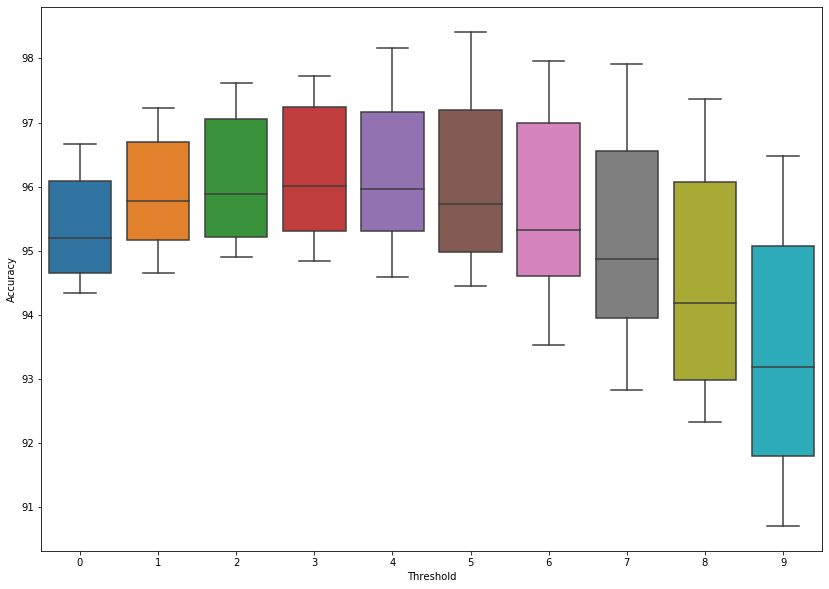

In [20]:
plt.figure(figsize=(14,10))
sns.boxplot(data=Threshold_acc_df,
            x='Threshold',
            y='Accuracy')

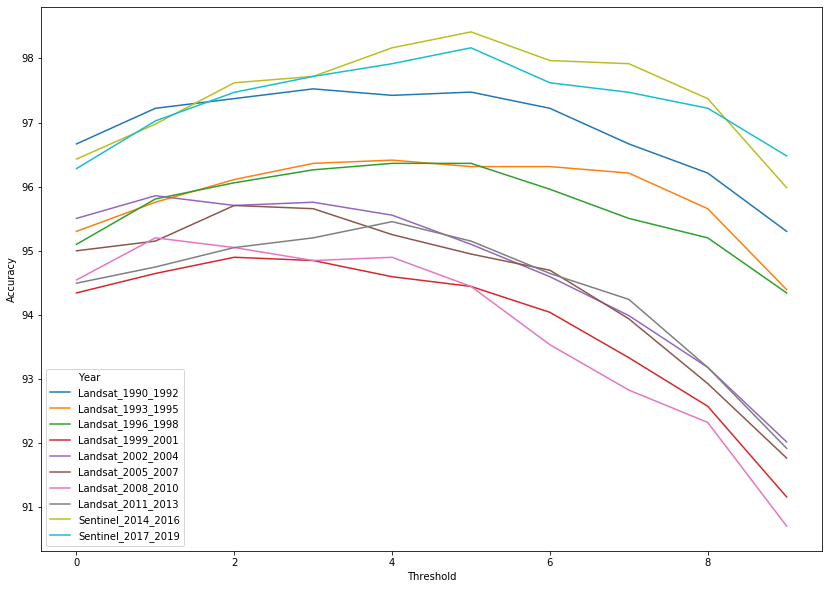

In [21]:
plt.figure(figsize=(14,10))
sns.lineplot(data=Threshold_acc_df,x='Threshold',y='Accuracy',hue='Year')

##### Observe that using the threshold of 5  increses the classification accuracy by 1 or 2 percent especiall at the two side of research period

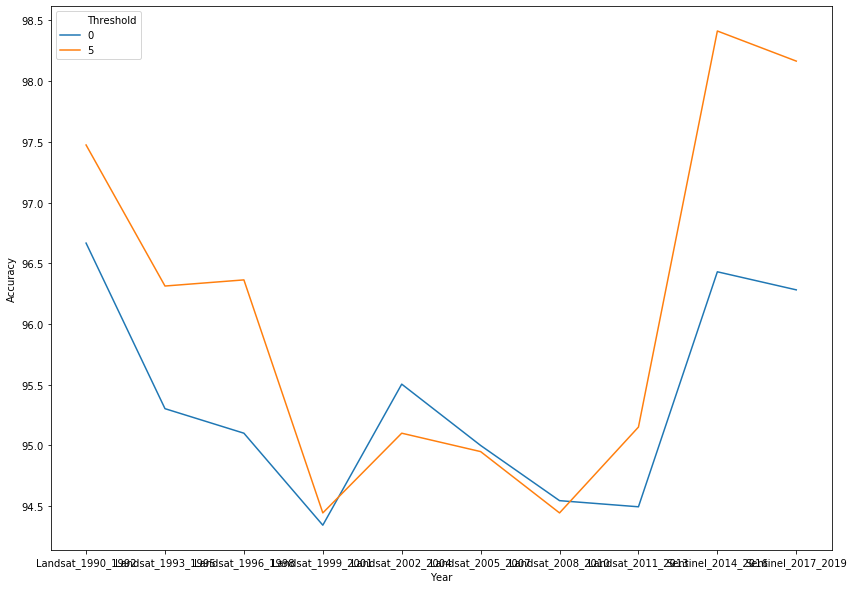

In [28]:
plt.figure(figsize=(14,10))
sns.lineplot(data =Threshold_acc_df[(Threshold_acc_df['Threshold']==5)|(Threshold_acc_df['Threshold']==0)],
             x ='Year',
             y ='Accuracy',
             hue = 'Threshold')